In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ctypes

from scipy.sparse import lil_matrix
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import NearestNeighbors
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from matplotlib import style
%matplotlib inline
style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", color_codes=True)

# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

In [2]:
# Dataset Link: https://www.kaggle.com/datasets/rdoume/beerreviews
df = pd.read_csv("./dataset/beer_reviews_medium.csv")
df.columns = ["breweryid", "brewery_name", "rating_time", "rating_overall", "rating_smell", "rating_look", "userid", "beer_style", "rating_feel", "rating_taste", "beer_name", "beer_abv", "beerid"]
df = df[["userid", "beerid", "rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_name", "beer_style", "brewery_name", "beer_abv", "breweryid", "rating_time"]]

df["beer_abv"].fillna(df["beer_abv"].mean(), inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(index=df[df["rating_overall"].isin([0.0])].index, inplace=True)
df["beer_full"] = df["beer_name"] + " (" + df["beer_style"] + ") by " + df["brewery_name"]
df.reset_index(drop=True, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249931 entries, 0 to 249930
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userid          249931 non-null  object 
 1   beerid          249931 non-null  int64  
 2   rating_overall  249931 non-null  float64
 3   rating_look     249931 non-null  float64
 4   rating_smell    249931 non-null  float64
 5   rating_taste    249931 non-null  float64
 6   rating_feel     249931 non-null  float64
 7   beer_name       249931 non-null  object 
 8   beer_style      249931 non-null  object 
 9   brewery_name    249931 non-null  object 
 10  beer_abv        249931 non-null  float64
 11  breweryid       249931 non-null  int64  
 12  rating_time     249931 non-null  int64  
 13  beer_full       249931 non-null  object 
dtypes: float64(6), int64(3), object(5)
memory usage: 26.7+ MB


In [4]:
df.head()

,userid,beerid,rating_overall,rating_look,rating_smell,rating_taste,rating_feel,beer_name,beer_style,brewery_name,beer_abv,breweryid,rating_time,beer_full
0,stcules,47986,1.5,2.5,2.0,1.5,1.5,Sausa Weizen,Hefeweizen,Vecchio Birraio,5.0,10325,1234817823,Sausa Weizen (Hefeweizen) by Vecchio Birraio
1,stcules,48213,3.0,3.0,2.5,3.0,3.0,Red Moon,English Strong Ale,Vecchio Birraio,6.2,10325,1235915097,Red Moon (English Strong Ale) by Vecchio Birraio
2,stcules,48215,3.0,3.0,2.5,3.0,3.0,Black Horse Black Beer,Foreign / Export Stout,Vecchio Birraio,6.5,10325,1235916604,Black Horse Black Beer (Foreign / Export Stout...
3,stcules,47969,3.0,3.5,3.0,3.0,2.5,Sausa Pils,German Pilsener,Vecchio Birraio,5.0,10325,1234725145,Sausa Pils (German Pilsener) by Vecchio Birraio
4,johnmichaelsen,64883,4.0,4.0,4.5,4.5,4.0,Cauldron DIPA,American Double / Imperial IPA,Caldera Brewing Company,7.7,1075,1293735206,Cauldron DIPA (American Double / Imperial IPA)...


In [5]:
df[["rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_abv"]].describe().T

,count,mean,std,min,25%,50%,75%,max
rating_overall,249931.0,3.871633,0.682615,1.00,3.5,4.0,4.5,5.0
rating_look,249931.0,3.904494,0.585477,1.00,3.5,4.0,4.5,5.0
rating_smell,249931.0,3.813078,0.661764,1.00,3.5,4.0,4.0,5.0
rating_taste,249931.0,3.867876,0.693023,1.00,3.5,4.0,4.5,5.0
rating_feel,249931.0,3.813180,0.648140,1.00,3.5,4.0,4.0,5.0
beer_abv,249931.0,7.324152,2.163466,0.05,5.5,7.0,9.0,57.7


<Axes: xlabel='rating_overall'>

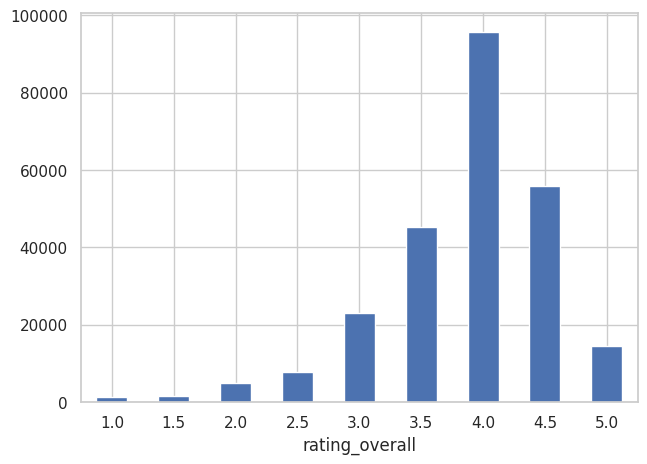

In [6]:
df["rating_overall"].value_counts().sort_index().plot(kind="bar", rot=0)

<Axes: >

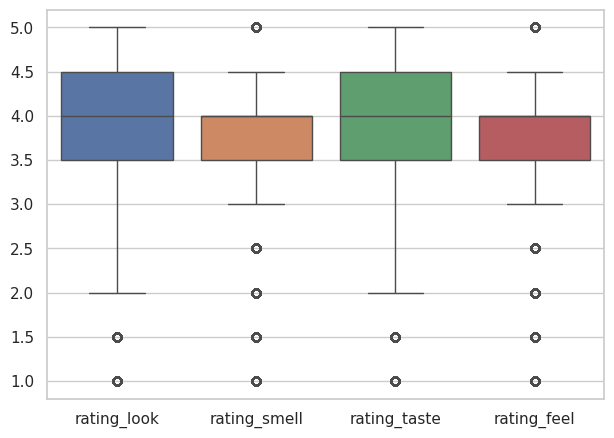

In [7]:
sns.boxplot(df[["rating_look", "rating_smell", "rating_taste", "rating_feel"]])

<Axes: xlabel='%ABV (Alcohol by volume)', ylabel='Frequency'>

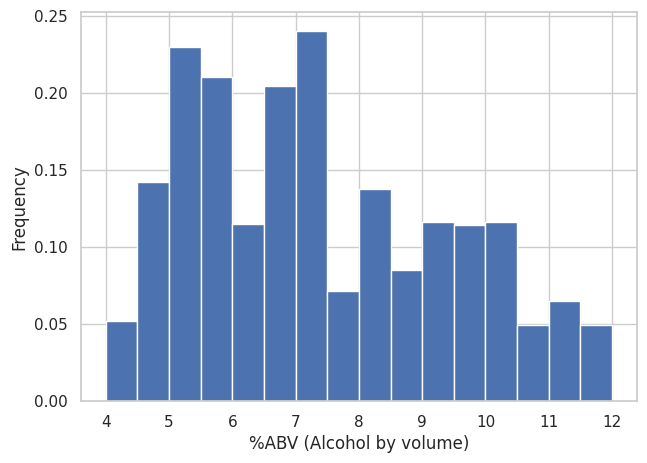

In [8]:
df["beer_abv"].plot(kind="hist", bins=16, range=[4, 12], density=True, xlabel="%ABV (Alcohol by volume)")

In [9]:
print("Most Popular Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beers


,mean,count
beer_full,,
Sierra Nevada Celebration Ale (American IPA) by Sierra Nevada Brewing Co.,4.168556,2999
Sierra Nevada Pale Ale (American Pale Ale (APA)) by Sierra Nevada Brewing Co.,4.245845,2587
Founders Breakfast Stout (American Double / Imperial Stout) by Founders Brewing Company,4.354658,2501
Sierra Nevada Bigfoot Barleywine Style Ale (American Barleywine) by Sierra Nevada Brewing Co.,3.966479,2491
Sierra Nevada Torpedo Extra IPA (American IPA) by Sierra Nevada Brewing Co.,4.104485,2029
Chimay Grande Réserve (Blue) (Belgian Strong Dark Ale) by Bières de Chimay S.A.,4.248631,2009
Racer 5 India Pale Ale (American IPA) by Bear Republic Brewing Co.,4.231608,1971
Founders KBS (Kentucky Breakfast Stout) (American Double / Imperial Stout) by Founders Brewing Company,4.396891,1930
Hop Rod Rye (Rye Beer) by Bear Republic Brewing Co.,4.217835,1912


In [10]:
print("Best Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean", ascending=False).head(10)

Best Rated Beers


,mean,count
beer_full,,
Founders CBS Imperial Stout (American Double / Imperial Stout) by Founders Brewing Company,4.591052,637
Silva Stout (American Double / Imperial Stout) by Green Flash Brewing Co.,4.399371,159
Founders KBS (Kentucky Breakfast Stout) (American Double / Imperial Stout) by Founders Brewing Company,4.396891,1930
Hunahpu's Imperial Stout (American Double / Imperial Stout) by Cigar City Brewing,4.365967,429
Founders Breakfast Stout (American Double / Imperial Stout) by Founders Brewing Company,4.354658,2501
AleSmith Speedway Stout - Barrel Aged (American Double / Imperial Stout) by AleSmith Brewing Company,4.354460,213
Southampton Saison (Saison / Farmhouse Ale) by Southampton Publick House,4.333333,114
AleSmith IPA (American IPA) by AleSmith Brewing Company,4.303477,949
AleSmith Speedway Stout (American Double / Imperial Stout) by AleSmith Brewing Company,4.284201,1133


In [11]:
print("Worst Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean").head(10)

Worst Rated Beers


,mean,count
beer_full,,
Heineken Premium Light Lager (Light Lager) by Heineken Nederland B.V.,2.628889,225
Hite (Euro Pale Lager) by Hite Brewery Company LTD,2.674312,109
Amstel Light (Light Lager) by Amstel Brouwerij B. V.,2.719355,465
Kennebunkport IPA (American IPA) by Federal Jack's Restaurant & Brew Pub,2.883621,116
Super Bock (American Adjunct Lager) by UNICER União Cervejeira S.A.,2.960000,100
Asahi Super Dry (Japanese Rice Lager) by Asahi Breweries Ltd,2.985782,422
Cherry Chocolate Beer (Fruit / Vegetable Beer) by O'Fallon Brewery,2.993902,164
Bourbon Barrel Stout (Clay Street Series) (American Stout) by Bluegrass Brewing Co. - East St. Matthew's,3.021930,114
Heineken Lager Beer (Euro Pale Lager) by Heineken Nederland B.V.,3.025237,1268


In [12]:
print("Most Popular Beer Styles")
df.groupby("beer_style").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beer Styles


,mean,count
beer_style,,
American IPA,4.065581,28217
American Double / Imperial Stout,4.117924,19466
American Double / Imperial IPA,3.953126,15883
American Pale Ale (APA),3.913452,11664
Russian Imperial Stout,4.081732,7910
American Amber / Red Ale,3.804465,7771
American Porter,3.902190,7627
American Barleywine,3.965770,6763
Tripel,3.844019,5818


In [13]:
print("Most Popular Breweries")
df.groupby("brewery_name").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Breweries


,mean,count
brewery_name,,
Sierra Nevada Brewing Co.,4.056182,28746
Founders Brewing Company,4.114475,20000
Southern Tier Brewing Company,3.878049,15867
Great Divide Brewing Company,3.965506,14930
New Belgium Brewing,3.852950,13407
Bear Republic Brewing Co.,4.153430,7857
Port Brewing Company / Pizza Port,3.997328,7297
The Bruery,3.945304,7176
Cigar City Brewing,4.022958,6708


In [14]:
rating, min_quality, min_quantity = "rating_overall", 3, 10
l1_reg, l2_reg = 0.001, 0.0001
threads = max(1, mp.cpu_count()-2)
N = 10

df = df[["userid", "beerid", rating, "beer_full"]]
df = df[df[rating] >= min_quality]
df_temp = df["userid"].value_counts()
df = df[df["userid"].isin(df_temp[df_temp >= min_quantity].index)]
df_temp = df["beerid"].value_counts()
df = df[df["beerid"].isin(df_temp[df_temp >= min_quantity].index)]
df.reset_index(drop=True, inplace=True)
U, T = np.sort(df["userid"].unique()), np.sort(df["beerid"].unique())
m, n = len(U), len(T)
df["userid"] = df["userid"].map({userid: index for index, userid in enumerate(U)})
df["beerid"] = df["beerid"].map({beerid: index for index, beerid in enumerate(T)})

model = ElasticNet(alpha=l1_reg+l2_reg,
                   l1_ratio=l1_reg/(l1_reg+l2_reg),
                   positive=True, fit_intercept=False, copy_X=False)
model_knn = NearestNeighbors(n_neighbors=int(n/10))

In [15]:
def get_train_test(df):
    test = df.groupby("userid", group_keys=False).apply(lambda grp: grp.sample(n=1))
    train = df.drop(test.index)
    return train, test

In [16]:
def get_A(train):
    A = lil_matrix((m, n))
    for row in zip(train["userid"], train["beerid"], train[rating]):
        A[row[0], row[1]] = row[2]
    return A

In [17]:
def get_A_hat(A):
    m, n = A.shape
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [18]:
def parallel(params):
    A = params[2]
    for j in range(params[0], params[1]):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W_[(index, j)] = w_j[index]

def get_A_hat_parallel(A):
    m, n = A.shape
    global W_
    W_ = np.ctypeslib.as_array(
        mp.Array(ctypes.c_double, n*n).get_obj()
        ).reshape(n, n)
    n_ = math.ceil(n/threads)
    params = []
    for i in range(threads-1):
        params.append([i*n_, (i+1)*n_, A])
    params.append([(i+1)*n_, n, A])
    with ProcessPoolExecutor() as executor:
        executor.map(parallel, params)
    return lil_matrix(A @ W_)

In [19]:
def get_A_hat_fs(A):
    m, n = A.shape
    A_csc = A.tocsc(copy=True)
    model_knn.fit(A.transpose(copy=True))
    nn = model_knn.kneighbors(return_distance=False)
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        model.fit(A_csc[:, nn[j]], a_j.toarray())
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [20]:
def get_recs(A_hat, A):
    m, n = A_hat.shape
    recs = []
    for i in range(m):
        recs.append([])
        for j in A_hat[i].nonzero()[1]:
            if (A[(i, j)] == 0):
                recs[-1].append((j, A_hat[(i, j)]))
        recs[-1].sort(key=lambda x: x[1], reverse=True)
        recs[-1] = [pair[0] for pair in recs[-1][:N]]
    return recs

In [21]:
def display_user_recs(df, recs, userid):
    print(f"Top {N} Beer Recommendations for User#{userid}\n")
    for rec in recs[userid]:
        print(df[df["beerid"] == rec]["beer_full"].tolist()[0])

In [22]:
def get_HR_ARHR(recs, test):
    test.reset_index(drop=True, inplace=True)
    HR, ARHR = 0, 0
    for i in range(m):
        try:
            p = recs[i].index(test["beerid"][i]) + 1
            HR += 1
            ARHR += (1 / p)
        except ValueError:
            continue
    return (HR/m, ARHR/m)

In [23]:
train, test = get_train_test(df)
A = get_A(train)

In [24]:
A_hat = get_A_hat(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.29740661432310256
Average Reciprocal Hit-Rank (ARHR): 0.13777866527688062


In [25]:
A_hat = get_A_hat_parallel(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.29740661432310256
Average Reciprocal Hit-Rank (ARHR): 0.13777866527688062


In [26]:
A_hat = get_A_hat_fs(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.025220080894599095
Average Reciprocal Hit-Rank (ARHR): 0.008798703873650343


In [27]:
HR_avg, ARHR_avg = [0.0, 0.0]
for i in range(5):
  train, test = get_train_test(df)
  A = get_A(train)
  A_hat = get_A_hat_parallel(A)
  recs = get_recs(A_hat, A)
  HR, ARHR = get_HR_ARHR(recs, test)
  HR_avg += HR
  ARHR_avg += ARHR
HR_avg /= 5
ARHR_avg /= 5
print(f"Hit Rate (HR): {HR_avg}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR_avg}")

Hit Rate (HR): 0.30563882940756604
Average Reciprocal Hit-Rank (ARHR): 0.13807850779299752
